With the Sentinel data we have certainly gained some insight into the spatial distribution of traffic. But still our model did not fit reality  very well. It seems that $\alpha$, which up to now we have assumed to be the same for every location, might in reality differ from place to place - meaning that some LKs have more success in reducing infection rates than others. 

Naively, we'd just add one $\alpha_x$ for every location $x$ to the list of our model parameters. However, this would result in us calibrating several hundreds of parameters - not usually an easy thing to do. We could however reduce the workload on our calibration algorithm if we found a good estimator for $\alpha_x$.

While there is (as far as I am aware) no analytical least-squares estimator for $\alpha_x$, simple arithmetic does get us very far:

$$ \alpha_x = \frac{dn(x, t)}{dt} \frac{1}{ \sum_y C_{y, x, t} n(y, t) } \frac{K - n(x, t)}{K} $$

Astonishingly, just taking the average of this expression over all pairs of observations $(n_{t-1}, n_t)$ yields a decent estimation.

$$ \hat{\alpha}_x = \sum_t (n(x, t) - n(x, t-1)) \frac{1}{ \sum_y C_{y, x, t} n(y, t) } \frac{K - n(x, t)}{K} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, animation
from IPython.display import HTML
import pandas as pd
import geopandas as gpd

from models import spatialModelNO2alpha, minimize, getMsseRelative
from plotting import plotSim, plotSimCuml, plotSimMulti, scatterHistory, video, getIndex



data = gpd.read_file('./data/landkreise_no2_30d.json')
dateColNames = data.columns[6:-5]

incubationTime = 7
t_infectious = 14
t_curfew = getIndex('22.03.2020', dateColNames)
t_curfew_effect = t_curfew + incubationTime

n_obs = data[dateColNames].values
nrPlaces, nrTimesteps = n_obs.shape
n0 = n_obs[:, 0]
population = data['population'].values
Ks = population
geometries = data.geometry

msseRelPop = getMsseRelative(population / 10000)

In [2]:
fsp0_est = 0.4
fsp0_bounds = (0.001, 1)
fsp1_est = 0.3
fsp1_bounds = (0.001, 1)
fTrafficMidn_est = 0.2
fTrafficMidn_bounds = (0.001, 1)

no2_before_day = data['obs_no2_mean_before']
no2_after_day = data['obs_no2_mean_after']
no2_before_night = data['obs_no2_midnight_mean_before']
no2_after_night = data['obs_no2_midnight_mean_after']


results_alpha, _ = minimize(n_obs, spatialModelNO2alpha,
            [fsp0_est, fsp1_est, fTrafficMidn_est],
            [fsp0_bounds, fsp1_bounds, fTrafficMidn_bounds],
            [Ks, geometries, t_curfew_effect, t_curfew, t_infectious, n_obs, no2_before_day, no2_after_day, no2_before_night, no2_after_night], 
            msseRelPop)
results_alpha

      fun: 2248011.7784486837
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-22524.92122352, -20799.64615405,      0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 56
      nit: 12
   status: 0
  success: True
        x: array([1.        , 1.        , 0.20861851])

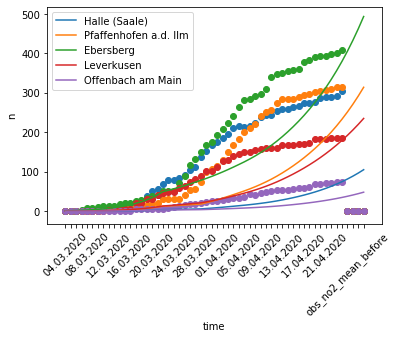

In [3]:
n_sim_alpha, connectivity0, connectivity1, alphas0, alphas1 = spatialModelNO2alpha(*(results_alpha.x),
                    Ks, geometries, t_curfew_effect, t_curfew, t_infectious, n_obs, no2_before_day, no2_after_day, no2_before_night,          
                    no2_after_night, True)


n_obs_plt = []
n_sim_plt = []
names = []
for i in range(0, 50, 10):
    n_obs_plt.append(n_obs[i])
    n_sim_plt.append(n_sim_alpha[i])
    names.append(data.loc[i, 'GEN'])
plotSimMulti(dateColNames, n_obs_plt, n_sim_plt, names)

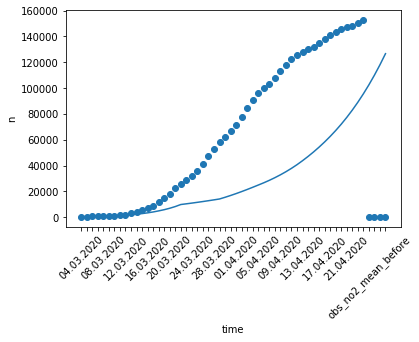

In [4]:
plotSimCuml(dateColNames, n_obs, n_sim_alpha)